In [1]:
###  RUN FROM SCRATCH  ### 

import argparse
import collections
from pathlib import Path
import csv
import os 

import numpy as np 

import torch
import torch.optim as optim
from torchvision import transforms, utils as vision_utils 
#from torch.utils.tensorboard import SummaryWriter

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer, BalancedSampler
from torch.utils.data import DataLoader

from retinanet.sampler import SamplerFactory, aggregate_indices_per_class 


from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'


MODELS_DIR = '/home/ubuntu/surgery-tool-detection/models/'
LOGS_DIR = '/home/ubuntu/surgery-tool-detection/logs/'

##MODELS_DIR = str(Path(__file__).resolve().parents[2]) + '/models/'
##LOGS_DIR = str(Path(__file__).resolve().parents[2]) + '/logs/'
# pretrained_model = MODELS_DIR + 'coco_resnet_50_map_0_335_state_dict.pt'

print('CUDA available: {}'.format(torch.cuda.is_available()))

print(MODELS_DIR) 

print(LOGS_DIR) 


### Set up model configs ### 

parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
parser.add_argument('--coco_path', help='Path to COCO directory')
parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')

parser.add_argument('--depth', help='Resnet depth, must be one of 18, 34, 50, 101, 152', type=int, default=50)
parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)
parser.add_argument('--model_name', help='Name to store the trianed model under.')
parser.add_argument('--log_output', help='Save output to csv file', action='store_true')
parser.add_argument('--batch_size', type=int)
parser.add_argument('--learning_rate', type=float)
parser.add_argument('--threshold', help='iou threshold to count as detection')
parser.add_argument('--sampler', help='Type of sampler to use, default aspect ratio sampler.')
parser.add_argument('--augment', action='store_true')
parser.add_argument('--pretrained', help='Path to pretrained model')
parser.add_argument('--blacken', action='store_true')

#parser = parser.parse_args(args)


##### PRIMARY MODEL CONFIGS TO SET ### 

parser.model_name = 'Augie' 
parser.depth = 50 
parser.epochs = 1 

#parser.sampler = None 
#parser.sampler = "old balanced (no alpha)" 
parser.sampler = 'new balanced' 

parser.alpha = 0.0 
parser.augment = 0.0 #False 
parser.pipeline = "lighting" #False 

##### END PRIMARY CONFIGS ######## 

parser.log_output = True 
LOG_DIR = LOGS_DIR + parser.model_name + '/'
os.makedirs(LOG_DIR, exist_ok=True) 

parser.dataset = 'csv' 
parser.csv_train = '/home/ubuntu/surgery-tool-detection/src/data/train_data.csv' #'../data/train_data.csv'
parser.csv_val = '/home/ubuntu/surgery-tool-detection/src/data/val_data.csv' #../val_data.csv 
parser.csv_raw = '/home/ubuntu/surgery-tool-detection/src/data/raw_data.csv' ### 
parser.csv_classes = '/home/ubuntu/surgery-tool-detection/src/data/class_names.csv' #../data/class_names.csv 


parser.blacken = False 
parser.learning_rate = None 

parser.batch_size = None ## Set and log config? 
parser.threshold = None ## Set and log config? 




model_name = 'model'
if parser.model_name is not None:
    model_name = parser.model_name

learning_rate = 1e-5
if parser.learning_rate is not None:
    learning_rate = float(parser.learning_rate)

batch_size = 2
if parser.batch_size is not None:
    batch_size = int(parser.batch_size)

threshold = 0.5
if parser.threshold is not None:
    threshold = float(parser.threshold)

    
    
    
# Create the dataloaders     

if parser.dataset == 'coco':

    if parser.coco_path is None:
        raise ValueError('Must provide --coco_path when training on COCO,')

    dataset_train = CocoDataset(parser.coco_path, set_name='train2017',
                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
    dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                              transform=transforms.Compose([Normalizer(), Resizer()]))

elif parser.dataset == 'csv':
    
    dataset_raw = CSVDataset(train_file=parser.csv_raw, class_list=parser.csv_classes, 
                             transform=transforms.Compose([Augmenter(), Resizer()]), 
                               augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken) 
    

    if parser.csv_train is None:
        raise ValueError('Must provide --csv_train when training on COCO,')

    if parser.csv_classes is None:
        raise ValueError('Must provide --csv_classes when training on COCO,')

#     dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
#                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]), 
#                                augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Augmenter(), Resizer()]), 
                               augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    train_acc_set = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Normalizer(), Resizer()]), blacken=parser.blacken)

    if parser.csv_val is None:
        dataset_val = None
        print('No validation annotations provided.')
    else:
        dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                                 transform=transforms.Compose([Normalizer(), Resizer()]))

else:
    raise ValueError('Dataset type not understood (must be csv or coco), exiting.')
    


sampler = AspectRatioBasedSampler(dataset_train, batch_size=batch_size, drop_last=False)
if parser.sampler is not None and parser.sampler == 'old balanced (no alpha)':
    sampler = BalancedSampler(dataset_train, batch_size=batch_size, drop_last=False) 
if parser.sampler is not None and parser.sampler == 'new balanced': 
    class_indices_dict = aggregate_indices_per_class(dataset_train) 
    class_indices = list(class_indices_dict.values()) 
    # print(len(class_indices)) 
    # for label in class_indices: print(len(label))
    #batch_sz = 2 
    # print("Hello") 
    # print(len(dataset_train)//batch_sz) 
    sampler = SamplerFactory().get(
        class_idxs=class_indices,
        batch_size=batch_size,
        n_batches=len(dataset_train)//batch_size,
        alpha=parser.alpha,
        kind='random'
    ) 
    
    
dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler) 


if dataset_val is not None:
    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)



/home/ubuntu/anaconda3/envs/tools/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/home/ubuntu/anaconda3/envs/tools/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


CUDA available: True
/home/ubuntu/surgery-tool-detection/models/
/home/ubuntu/surgery-tool-detection/logs/
Using new Balanced Sampler


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 3428 out of 3428 (100.0%)
2573 clean
854 bad
75.1% clean


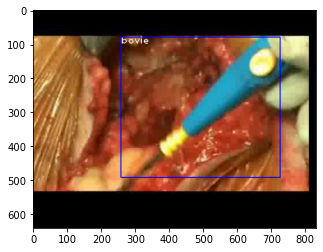

Clean? y


In [2]:
import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer
unnormalize = UnNormalizer()      
         
    
# Do this for every image in the dataset_raw 
# And then dump into a pruning.json 

dataset = dataset_raw 

clean = [] 
bad = [] 


def displayFilenameAnnotations(filename): 
    index = dataset.image_names.index(filename) 
    sample = dataset[index] 
    image = np.array(sample['img']) 
    annots = np.array(sample['annot']) 
    def draw_caption(image, box, caption): 
        b = np.array(box).astype(int)
        cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
    for annot in annots:
        if annot[4] == -1: 
            continue 
        label_name = dataset.labels[annot[4]] 
        x1 = int(annot[0])
        y1 = int(annot[1])
        x2 = int(annot[2])
        y2 = int(annot[3])
        draw_caption(image, (x1, y1, x2, y2), label_name)
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  
    plt.imshow(image) 
    plt.show() 
    
num_clean = 0 
num_bad = 0 

for idx, filename in enumerate(dataset.image_names): 
    #if idx > 10: break 
    print("Image {} out of {} ({}%)".format(idx+1, len(dataset), round((idx+1)/len(dataset)*100, 1))) 
    print("{} clean".format(num_clean))  
    print("{} bad".format(num_bad)) 
    percent_clean = 0 if num_clean+num_bad == 0 else round(num_clean/(num_clean+num_bad)*100, 1)
    print("{}% clean".format(percent_clean)) 
    displayFilenameAnnotations(filename) 
    
    while True:
        answer = input("Clean? ") 
        if answer not in ("y", "n"):
            print("Not an appropriate choice.") 
        else:
            break

    if answer == "y": 
        clean.append(filename) 
        num_clean += 1 
    if answer == "n": 
        bad.append(filename) 
        num_bad += 1
     
    from IPython.display import clear_output
    clear_output(wait=True) #False 
    
        


In [3]:
print(len(clean)) 
print(len(bad))
print(len(clean) + len(bad)) 
print(clean) 
print(bad) 

# Dump into json 

data = {} 
data["clean"] = clean 
data["bad"] = bad 

import json 
with open('pruning.json', 'w') as f:
    json.dump(data, f)

2574
854
3428
['/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000001397.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000001863.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000002795.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000003261.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000003727.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000005125.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000737.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000983.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001721.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001967.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002213.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002705.jpg', '/home/ubuntu/tools_data/data/images/dLap-hcBxc0-000000455.jpg', '/home/ubuntu/tools_data/data/images/dLap-hcBxc0-000000607.jpg', '/home/ubuntu/tools_data/data/images/dLap-hcBxc0-000000759.jpg', '/home/ubu

In [5]:
# Re-do cell (don't repeat) 

print(len(clean)) 
print(len(bad))
print(len(clean) + len(bad)) 
print(clean) 
print(bad) 

# Dump into json 

clean_ = [] 
bad_ = [] 

for file in clean: 
    filename = file.rsplit('/',1)[1] 
    clean_.append(filename) 
    
for file in bad: 
    filename = file.rsplit('/',1)[1] 
    bad_.append(filename) 
    
print(len(clean_)) 
print(len(bad_))
print(len(clean_) + len(bad_)) 
print(clean_) 
print(bad_) 

data = {} 
data["clean"] = clean_ 
data["bad"] = bad_ 

import json 
with open('pruning.json', 'w') as f:
    json.dump(data, f)

2574
854
3428
['/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000001397.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000001863.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000002795.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000003261.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000003727.jpg', '/home/ubuntu/tools_data/data/images/c7zxUjQSusQ-000005125.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000737.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000983.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001721.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001967.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002213.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002705.jpg', '/home/ubuntu/tools_data/data/images/dLap-hcBxc0-000000455.jpg', '/home/ubuntu/tools_data/data/images/dLap-hcBxc0-000000607.jpg', '/home/ubuntu/tools_data/data/images/dLap-hcBxc0-000000759.jpg', '/home/ubu

In [ ]:
# for filename in clean: 
#     print("Clean") 
#     displayFilenameAnnotations(filename) 

In [ ]:
# for filename in bad: 
#     print("Bad") 
#     displayFilenameAnnotations(filename) 

In [7]:

# Start by loading in json 
#Keeping track of what's there 


# Do the process, with a new CSVDataset built from raw data json 


# Then keep adding to the json on each iteration 